# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
def argmax_rand(a):
    return np.random.choice(np.flatnonzero(a == a.max()))

In [4]:
def check_context(context, narms):
    if context is not None:
            assert isinstance(context, np.ndarray), "'context' must be a numpy.ndarray or None"
            assert np.issubdtype(context.dtype, np.floating), "'context' must be of type float"
            assert context.size % narms == 0, "size of 'context' is inconsistent with 'narms'"

In [5]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability in interval [0.0, 1.0]

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        # --- Input validity checks --- #
        assert np.issubdtype(type(narms), np.integer) and narms > 0, \
            "'narms' must be a positive integer"
        assert np.issubdtype(type(epsilon), np.floating) and epsilon >= 0 and epsilon <= 1, \
            "'epsilon' must be a float in the interval [0.0, 1.0]"
        assert np.issubdtype(type(Q0), np.floating), \
            "'Q0' must be a float"
        
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.num_pulls = np.zeros(narms)
        self.mean_rewards = np.full(narms, Q0)
        
    def play(self, tround, context=None):
        # --- Input validity checks --- #
        assert np.issubdtype(type(tround), np.integer) and tround > 0, "'tround' must be a positive integer"
        check_context(context, self.narms)
        
        if np.random.binomial(1, self.epsilon):
            # Explore
            return np.random.randint(1, self.narms + 1)
        else:
            # Exploit
            return argmax_rand(self.mean_rewards) + 1
        
    def update(self, arm, reward, context=None):
        # --- Input validity checks --- #
        assert np.issubdtype(type(arm), np.integer) and arm <= self.narms and arm >= 1, \
            "'arm' must be an int in the range [1, {}]".format(self.narms)
        assert np.issubdtype(type(reward), np.floating), "'reward' must be a float"
        check_context(context, self.narms)
        
        arm_0 = arm - 1
        n = self.num_pulls[arm_0]
        if n > 0:
            self.mean_rewards[arm_0] = (self.mean_rewards[arm_0] * n + reward) / (n + 1)
        else:
            self.mean_rewards[arm_0] = reward
        self.num_pulls[arm_0] += 1

In [6]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        # --- Input validity checks --- #
        assert np.issubdtype(type(narms), np.integer) and narms > 0, \
            "'narms' must be a positive integer"
        assert np.issubdtype(type(rho), np.floating) and rho > 0, \
            "'rho' must be a positive float"
        assert np.issubdtype(type(Q0), np.floating), \
            "'Q0' must be a float"
        
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.num_pulls = np.zeros(narms)
        self.mean_rewards = np.full(narms, self.Q0)
    
    def play(self, tround, context=None):
        # --- Input validity checks --- #
        assert np.issubdtype(type(tround), np.integer) and tround > 0, "'tround' must be a positive integer"
        check_context(context, self.narms)
        
        Q_prev = np.copy(self.mean_rewards)
        if (tround > 1):
            pulled_prev = self.num_pulls > 0
            Q_prev[pulled_prev] += np.sqrt(self.rho * np.log(tround) / self.num_pulls[pulled_prev])
        return argmax_rand(Q_prev) + 1
        
    def update(self, arm, reward, context=None):
        # --- Input validity checks --- #
        assert np.issubdtype(type(arm), np.integer) and arm <= self.narms and arm >= 1, \
            "'arm' must be an int in the range [1, {}]".format(self.narms)
        assert np.issubdtype(type(reward), np.floating), "'reward' must be a float"
        check_context(context, self.narms)
        
        arm_0 = arm - 1
        n = self.num_pulls[arm_0]
        if n > 0:
            self.mean_rewards[arm_0] = (self.mean_rewards[arm_0] * n + reward) / (n + 1)
        else:
            self.mean_rewards[arm_0] = reward
        self.num_pulls[arm_0] += 1

## 2. Off-Policy Evaluation

In [7]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    # --- Input validity checks --- #
    # Check types
    assert isinstance(mab, MAB), "'mab' must be an instance of MAB"
    for arrayName in ['arms', 'rewards', 'contexts']:
        assert isinstance(eval(arrayName), np.ndarray), "'{}' must be a numpy.ndarray".format(arrayName)
    assert (np.issubdtype(type(nrounds), np.integer) and nrounds >= 0) or (nrounds is None), \
        "'nrounds' must be a non-negative integer or None"
    # Check dtypes
    assert np.issubdtype(arms.dtype, np.integer), "'arms' must be of type int"
    assert np.issubdtype(rewards.dtype, np.floating), "'rewards' must be of type float"
    assert np.issubdtype(contexts.dtype, np.floating), "'contexts' must be of type float"
    # Check array dimensions
    assert arms.ndim == 1, "'arms' must be a 1D array"
    assert rewards.ndim == 1, "'rewards' must be a 1D array"
    assert contexts.ndim == 2, "'contexts' must be a 2D array"
    assert arms.shape[0] == rewards.shape[0] == contexts.shape[0], \
        "first dimension of input arrays are inconsistent"
    assert contexts.shape[1] % mab.narms == 0, "'contexts' has inconsistent second dimension"
    # Check range of arms
    assert arms.max() <= mab.narms and arms.min() >= 1, "'arms' contains ids that are out-of-range"
    
    matched_ctr = 0
    matched_rewards = list()
    for i in range(arms.size):
        if nrounds is not None and matched_ctr >= nrounds:
            break
        arm = mab.play(matched_ctr + 1, contexts[i])
        if arm == arms[i]:
            mab.update(arm, rewards[i], contexts[i])
            matched_ctr += 1
            matched_rewards.append(rewards[i])
    return np.array(matched_rewards)

In [8]:
# Load event log from a bandit run
dataset = np.genfromtxt('dataset.txt', dtype=np.int)
arms = dataset[:,0]
rewards = dataset[:,1].astype(float)
contexts = dataset[:,2::].astype(float)

In [9]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26625


In [10]:
mab = UCB(10, 1.0, 0.5)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.17125


## 3. Contextual Bandits

In [11]:
from numpy.linalg import inv

In [12]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        # --- Input validity checks --- #
        assert np.issubdtype(type(narms), np.integer) and narms > 0, "'narms' must be a positive integer"
        assert np.issubdtype(type(ndims), np.integer) and ndims > 0, "'ndims' must be a positive integer"
        assert np.issubdtype(type(alpha), np.floating) and alpha > 0, "'alpha' must be a positive float"
        
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.As = np.broadcast_to(np.eye(ndims), (narms, ndims, ndims)).copy()
        self.bs = np.zeros((narms, ndims))
        
    def play(self, tround, context):
        # --- Input validity checks --- #
        assert np.issubdtype(type(tround), np.integer) and tround > 0, "'tround' must be a positive integer"
        check_context(context, self.narms)
        
        context = np.reshape(context, newshape=(self.narms, -1))
        p_t = np.empty(self.narms)
        for i in range(self.narms):
            A_inv = inv(self.As[i])
            x = context[i]
            theta = A_inv @ self.bs[i]
            p_t[i] = theta.dot(x) + self.alpha * np.sqrt(x.dot(A_inv @ x))
        return argmax_rand(p_t) + 1
    
    def update(self, arm, reward, context):
        # --- Input validity checks --- #
        assert np.issubdtype(type(arm), np.integer) and arm <= self.narms and arm >= 1, \
            "'arm' must be an int in the range [1, {}]".format(self.narms)
        assert np.issubdtype(type(reward), np.floating), "'reward' must be a float"
        check_context(context, self.narms)
        
        arm0 = arm - 1
        x = np.reshape(context, newshape=(self.narms, -1))[arm0]
        self.As[arm0] += np.outer(x, x)
        self.bs[arm0] += reward * x

In [13]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

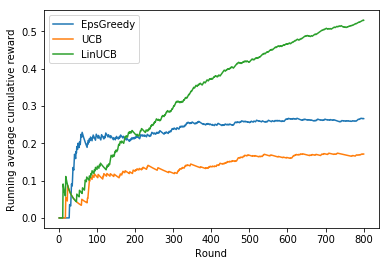

In [14]:
for mab in ['EpsGreedy', 'UCB', 'LinUCB']:
    results = eval('results_' + mab)
    tround = np.arange(1, results.size + 1)
    cumsum = np.cumsum(results)/tround
    plt.plot(tround, cumsum, label=mab)
plt.legend()
plt.xlabel('Round')
plt.ylabel('Running average cumulative reward')
plt.show()

### 4.B.

Note: the spec for this part was purposely vague.

Students are free to use any sensible evaluation measure (here we use the expected cumulative reward, estimated with a sample size of 10).

The specifics for the grid search (e.g. resolution/range of alpha values) is also left to the student's discretion.

Best alpha is 0.01


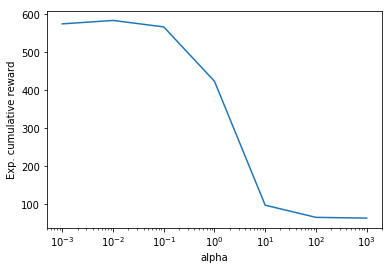

In [15]:
import copy

def exp_cum_reward(mab, arms, rewards, contexts, nrounds, nsamples):
    """
    Estimates the expected cumulative reward for a multi-armed bandit using offline evaluation
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int
        number of matching events to evaluate `mab` on.
    
    nsamples : int
        number of samples to use for estimate
    """
    cum_rewards = np.empty(nsamples)
    for i in range(nsamples):
        mab_copy = copy.deepcopy(mab) # Use a copy, since mab can't be reset
        cum_rewards[i] = offlineEvaluate(mab_copy, arms, rewards, contexts, nrounds).sum()
    return {'mean': cum_rewards.mean(), 'stderr': np.std(cum_rewards)/np.sqrt(nsamples)}

alpha_range = np.logspace(-3, 3, num=7)
nrounds = 800
nsamples = 10
narms = 10
ndim = 10
scores = np.zeros_like(alpha_range)
errors = np.zeros_like(alpha_range)
for i, alpha in enumerate(alpha_range):
    mab = LinUCB(narms, ndim, alpha)
    results = exp_cum_reward(mab, arms, rewards, contexts, nrounds, nsamples)
    scores[i] = results['mean']
    errors[i] = results['stderr']

print('Best alpha is {}'.format(alpha_range[np.argmax(scores)]))

plt.errorbar(alpha_range, scores, yerr=errors)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Exp. cumulative reward')
plt.show()

## 5. KernelUCB

In [10]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [48]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        # --- Input validity checks --- #
        assert np.issubdtype(type(narms), np.integer) and narms > 0, "'narms' must be a positive integer"
        assert np.issubdtype(type(ndims), np.integer) and ndims > 0, "'ndims' must be a positive integer"
        assert np.issubdtype(type(gamma), np.floating) and gamma > 0, "'gamma' must be a positive float"
        assert np.issubdtype(type(eta), np.floating) and eta > 0, "'eta' must be a positive float"
        assert callable(kern), "'kern' must be a callable"
        
        self.narms = narms
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.Kinv = np.empty(0, dtype=float)
        self._rewards = np.zeros(0, dtype=float)
        self._contexts = np.zeros((0, ndims), dtype=float)
        
    def play(self, tround, context):
        # --- Input validity checks --- #
        assert np.issubdtype(type(tround), np.integer) and tround > 0, "'tround' must be a positive integer"
        check_context(context, self.narms)
        
        if tround > 1:
            context = np.reshape(context, newshape=(self.narms, -1))
            #kxx = np.array([mab.kern(c,c)[0,0] for c in context[:,np.newaxis]])
            kxx = self.kern(context).diagonal()
            kx = self.kern(context, self._contexts)
            predictions = np.dot(kx, self.Kinv @ self._rewards)
            variances = kxx - np.sum(kx.T * (self.Kinv @ kx.T), axis=0)
            u = predictions + self.eta/(np.sqrt(self.gamma)) * np.sqrt(variances)
        else:
            u = np.zeros(self.narms)
            u[0] = 1
        
        return argmax_rand(u) + 1
    
    def update(self, arm, reward, context):
        # --- Input validity checks --- #
        assert np.issubdtype(type(arm), np.integer) and arm <= self.narms and arm >= 1, \
            "'arm' must be an int in the range [1, {}]".format(self.narms)
        assert np.issubdtype(type(reward), np.floating), "'reward' must be a float"
        check_context(context, self.narms)
        
        arm0 = arm - 1
        context = np.reshape(context, newshape=(self.narms, -1))
        
        # Record history of reward/contexts
        self._rewards = np.append(self._rewards, reward)
        self._contexts = np.append(self._contexts, context[arm0, np.newaxis], axis=0)
        
        # Update Kinv
        kx = self.kern(context, self._contexts)
        if kx.shape[1] == 1:
            self.Kinv = 1/(kx[arm0, np.newaxis] + self.gamma)
        else:
            b = kx[arm0,0:-1]
            b_Kinv = b @ self.Kinv
            Kinv_b = self.Kinv @ b
            
            K22 = 1/(kx[arm0,-1] + self.gamma - np.dot(b, Kinv_b))
            K11 = self.Kinv + K22 * np.outer(Kinv_b, b_Kinv)
            K12 = -K22 * Kinv_b[:,np.newaxis]
            K21 = -K22 * b_Kinv[np.newaxis]
            self.Kinv = np.block([[K11, K12], [K21, K22]])

In [49]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.71875


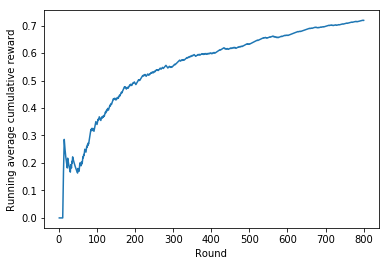

In [50]:
tround = np.arange(1, results_KernelUCB.size + 1)
plt.plot(tround, np.cumsum(results_KernelUCB)/tround)
plt.xlabel('Round')
plt.ylabel('Running average cumulative reward')
plt.show()